# **Предсказание цен на недвижимость**

Цель проекта - построить модель для предсказания цен на недвижимость (квартиры).

Задачи проекта:

1. Загрузить и провести анализ данных на дубликаты, выбросы, пропуски.
2. Провести анализ моделей, построенных на обучающей выборке. Выбрать лучшую модель на основе метрики R2.
3. Предсказать цену на недвижимоть для тестовых данных.

Признаки

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Целевой признак:

Price - цена квартиры



# Подготовка данных

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

%matplotlib inline

from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

In [336]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
    print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

Считываем данные

In [337]:
df = pd.read_csv('./train.csv', sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [441]:
df_test = pd.read_csv('./test.csv', sep=',')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [339]:
df.shape[1]

20

In [340]:
df.shape[1]-1 == df_test.shape[1]

True

Количество признаков в обучаещем и тестовом датасетах совпали.

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

На основе информации о типах данных признаков и их описании поменяем типы данных признаков на более приемлемые.

In [342]:
df['HouseFloor'] = df['HouseFloor'].fillna(0).astype('int64')

In [343]:
df['Rooms'] = df['Rooms'].fillna(0).astype('int64')

Воспользуемся фукцией reduce_mem_usage для уменьшения объема памяти, который занимает датасет

In [344]:
def reduce_mem_usage(df):
    """iterate through all the comuns of a dataframe and modify the data type
       to reduce memory usage.
    """
    start_mem = df.memory_usage().sum()/1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))   
    
    return df

In [345]:
df2 = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.43 MB
Decreased by 71.8%


Размер даных уменьшился на 72%. В данном случае датафрейм был невелик, но при работе с большим объемом информации, такое преобразование данных может существенно ускорить работу при создании и подбора модели. 

### Анализ целевого признака Price<a class='anchor' id='reduce'/>

In [346]:
df2.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839512,21.058718,86.241112,28.561113,5.241148,6.775974,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


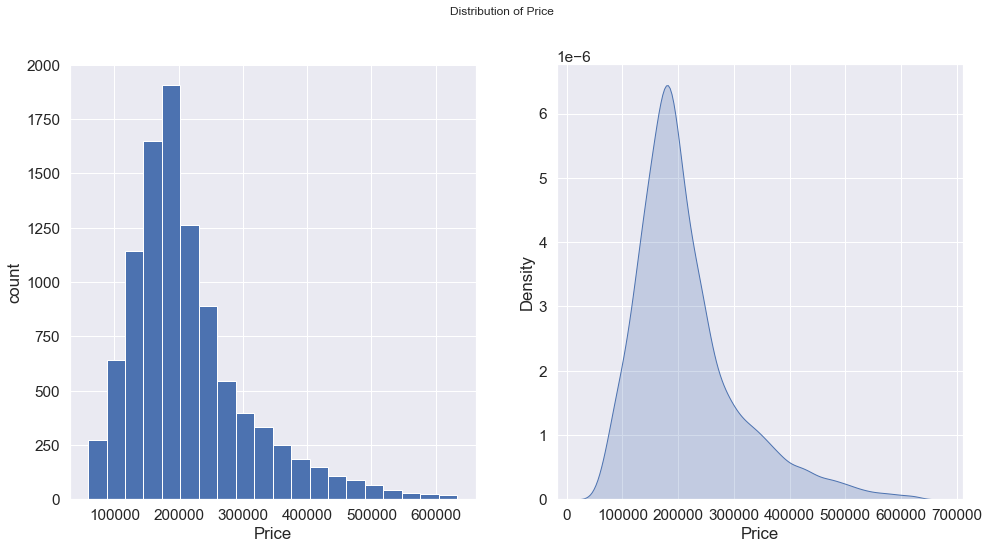

In [347]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df2['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [348]:
target_mean = round(df2['Price'].mean(), 2)
target_median = df2['Price'].median()
target_mode = df2['Price'].mode()[0]

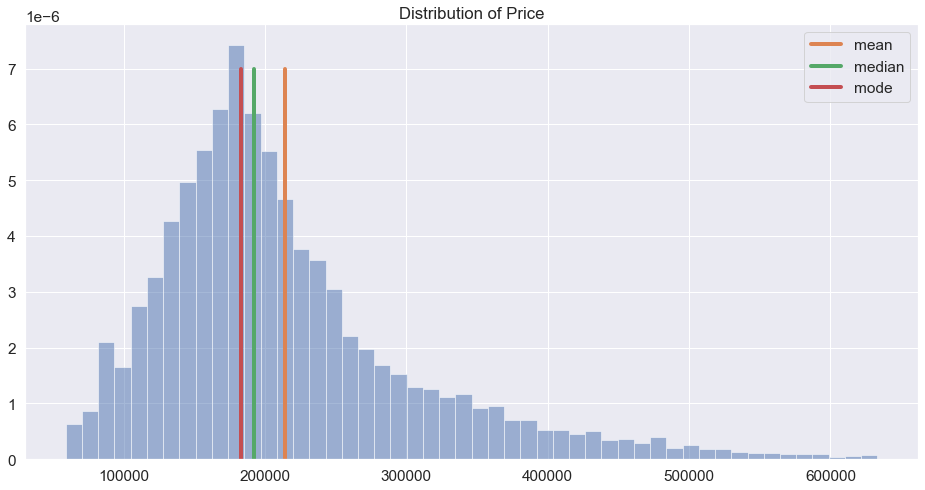

In [349]:
plt.figure(figsize = (16, 8))
plt.hist(df2['Price'], density=True, bins=50, alpha=0.5)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

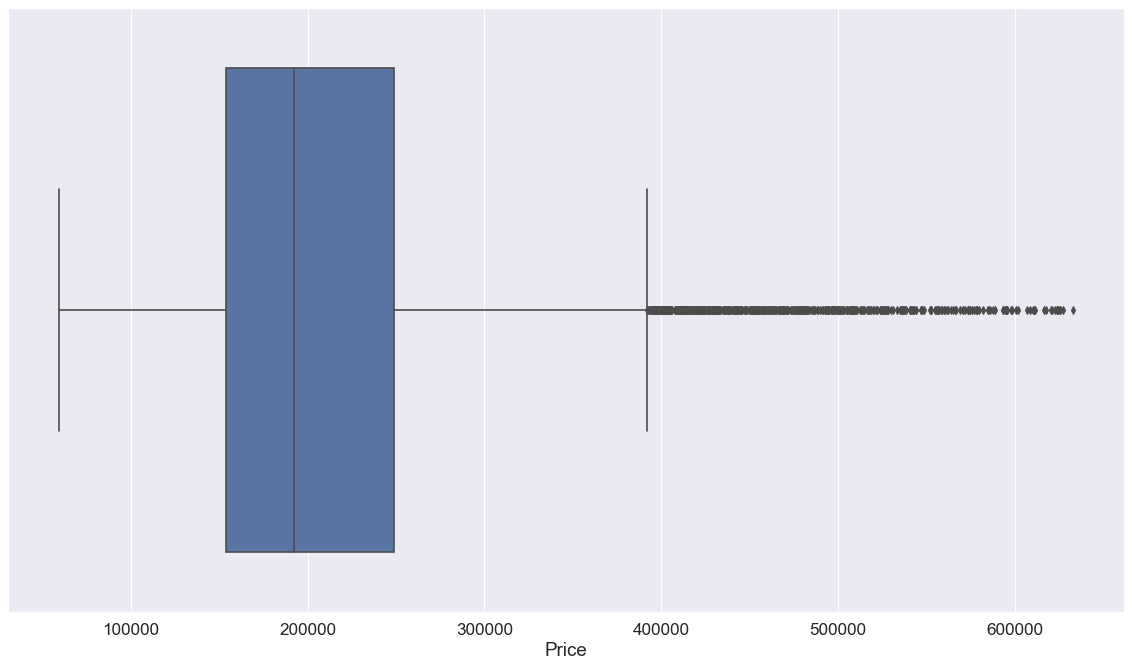

In [350]:
fig, ax = plt.subplots(figsize = (18,10), dpi= 80)
sns.boxplot(df2['Price'])

plt.show()

In [351]:
df2.loc[df2.Price > df2.Price.quantile(0.975), 'Price'].count()

250

Для целевой переменной было решено оставить выбросы, так как это лишь 2.5% данных.

### Обработка пропусков<a class='anchor' id='reduce'>

In [352]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Из информации датафрейма, есть два признака с пропусками: LifeSquare и Healthcare_1

In [353]:
for col in df2.columns:
    pct_missing = np.mean(df2[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Id - 0%
DistrictId - 0%
Rooms - 0%
Square - 0%
LifeSquare - 21%
KitchenSquare - 0%
Floor - 0%
HouseFloor - 0%
HouseYear - 0%
Ecology_1 - 0%
Ecology_2 - 0%
Ecology_3 - 0%
Social_1 - 0%
Social_2 - 0%
Social_3 - 0%
Healthcare_1 - 48%
Helthcare_2 - 0%
Shops_1 - 0%
Shops_2 - 0%
Price - 0%


In [354]:
df2.LifeSquare.isna().sum(), df2.Healthcare_1.isna().sum()

(2113, 4798)

21% пропусков для признака LifeSquare и 48% пропусков для признака Healthcare_1.

In [355]:
df2.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839512,21.058718,86.241112,28.561113,5.241148,6.775974,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [356]:
df2.LifeSquare.median(), df2.LifeSquare.mode()[0]

(32.7812614440918, 33.859653)

In [357]:
df2.Healthcare_1.median(), df2.Healthcare_1.mode()[0]

(900.0, 540.0)

Так как медиана меньше подвержена выбросам, то заменем пропуски медианой.

In [358]:
df2.LifeSquare = df.LifeSquare.fillna(df2.LifeSquare.median())
df2.Healthcare_1 = df2.Healthcare_1.fillna(df2.Healthcare_1.median())

In [359]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     10000 non-null  float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   10000 non-null  float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Обработка выбросов и нулевых значений для числовых признаков<a class='anchor' id='reduce'/>

In [360]:
df2_num_features = df2.select_dtypes(include=['float32', 'float16', 'int32', 'int8'])
df2_num_features.drop('Price', axis=1, inplace=True)

In [361]:
df2_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,36.266048,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,1026.358887,1.319500,4.231300
std,0.839512,21.058718,76.609917,28.561113,5.241148,6.775974,2.005003e+05,0.119026,17.532614,746.645447,1.493601,4.806341
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,25.527400,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,830.000000,0.000000,1.000000
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,900.000000,1.000000,3.000000
75%,2.000000,65.900627,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,990.000000,2.000000,6.000000
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,4849.000000,6.000000,23.000000


In [362]:
df2_num_features[df2_num_features == 0].count()

Rooms               8
Square              0
LifeSquare          0
KitchenSquare     697
Floor               0
HouseFloor        269
HouseYear           0
Ecology_1         537
Social_1          201
Healthcare_1        1
Helthcare_2      4214
Shops_1          2316
dtype: int64

In [363]:
# Признак Rooms
df2_num_features.Rooms.value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

Для признака Rooms преобладают значение 2, и количество комнат 0, 10 и 19 посчитаем за выбросы, они составляют 0.11% от всего количества, заменем их значения на медианное. 

In [364]:
df2.loc[df2['Rooms'].isin([0,10,19]),'Rooms'] = df2['Rooms'].median()

In [365]:
df2.Rooms.value_counts()

2    3891
1    3705
3    2235
4     150
5      18
6       1
Name: Rooms, dtype: int64

In [366]:
# Square, Life Square, Kitchen Square
df2[df2 == 0].count()

Id                  1
DistrictId         48
Rooms               0
Square              0
LifeSquare          0
KitchenSquare     697
Floor               0
HouseFloor        269
HouseYear           0
Ecology_1         537
Ecology_2           0
Ecology_3           0
Social_1          201
Social_2            0
Social_3         2997
Healthcare_1        1
Helthcare_2      4214
Shops_1          2316
Shops_2             0
Price               0
dtype: int64

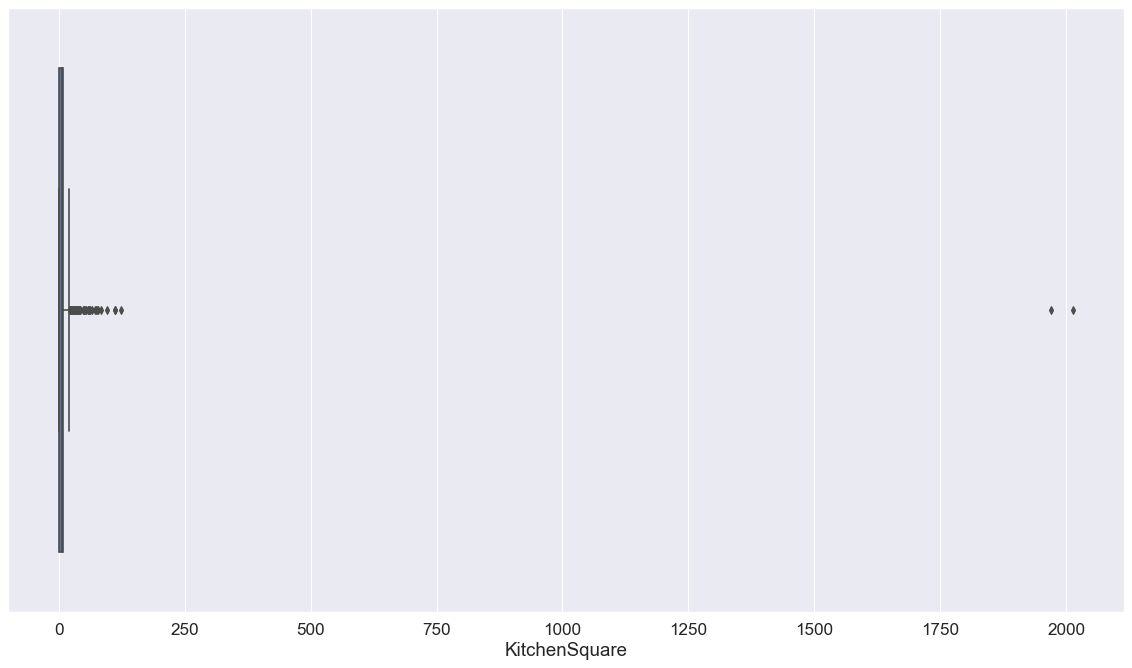

In [367]:
fig, ax = plt.subplots(figsize = (18,10), dpi= 80)
sns.boxplot(df2['KitchenSquare'])

plt.show()

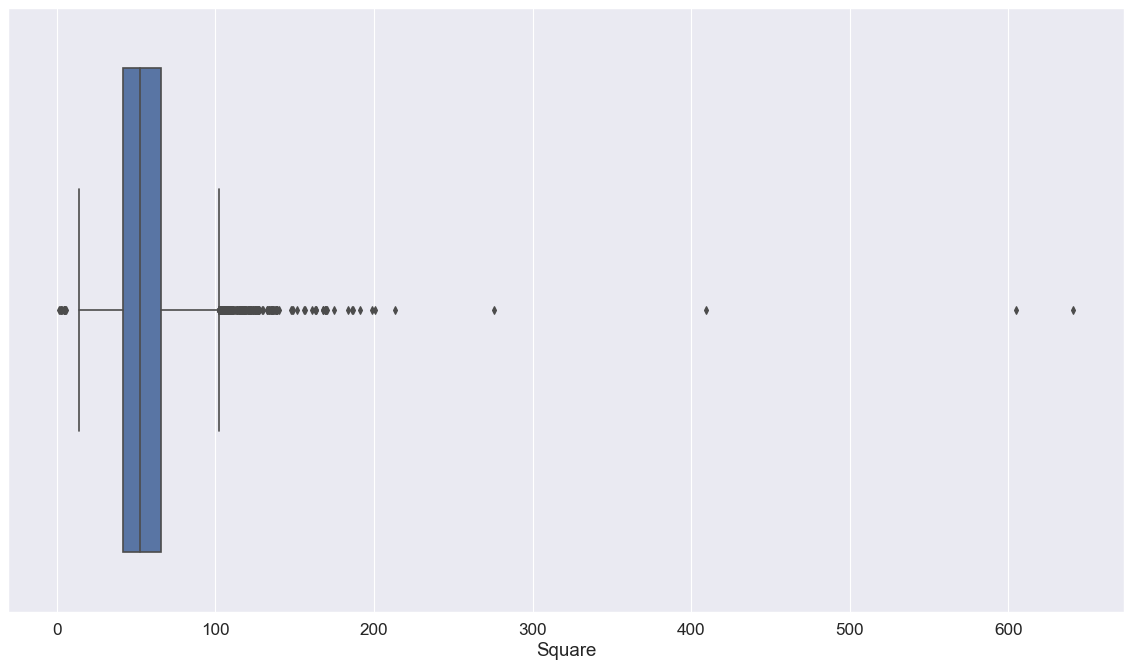

In [368]:
fig, ax = plt.subplots(figsize = (18,10), dpi= 80)
sns.boxplot(df2['Square'])

plt.show()

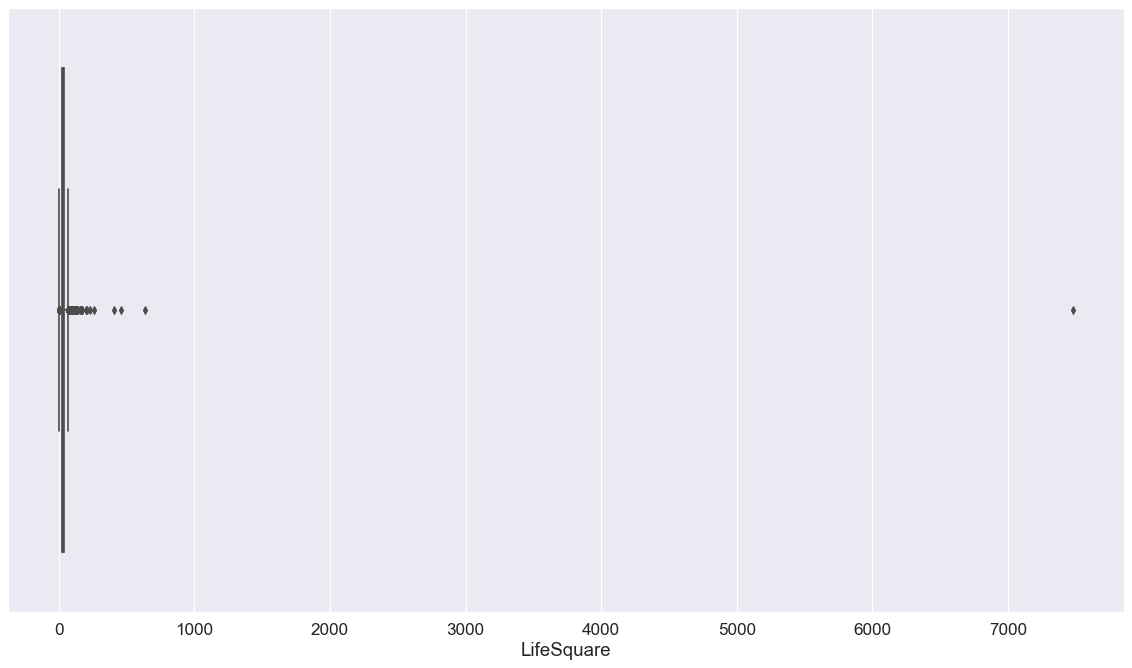

In [369]:
fig, ax = plt.subplots(figsize = (18,10), dpi= 80)
sns.boxplot(df2['LifeSquare'])

plt.show()

Удалим значения-выбросы, которые находятся за пределами квантилей 0.975 и 0.025. Нулевые значения для признака Kitchen Square заменим значением 0.25 квантиля.

In [370]:
# Kitchen Square
df2 = df2[df2['KitchenSquare'] < df2['KitchenSquare'].quantile(0.975)]
df2.loc[df2['KitchenSquare'] < df2['KitchenSquare'].quantile(0.25), 'KitchenSquare'] = df2['KitchenSquare'].quantile(0.25)

In [371]:
# Square
df2 = df2[(df2['Square'] < df2['Square'].quantile(0.975)) | 
         (df2['Square'] > df2['Square'].quantile(0.025))]

In [372]:
# Life Square
df2 = df2[(df2['LifeSquare'] < df2['LifeSquare'].quantile(0.975)) | 
         (df2['LifeSquare'] > df2['LifeSquare'].quantile(0.025))]

In [373]:
df2.shape

(9744, 20)

In [374]:
# HouseFloor, Floor
df2.HouseFloor.sort_values().unique(), df2.Floor.sort_values().unique()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  32,  37,  38,  39,  40,  44,  45,  48,
         99, 117], dtype=int8),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
       dtype=int8))

Так как недвижимость не может иметь этажность 0, то заменем нулевые значения (3% данных) признака HouseFloor на медианное.

In [375]:
df2.loc[df2.HouseFloor == 0, 'HouseFloor'] = df2.HouseFloor.median()

In [376]:
floor_outliers = df2.loc[df2.Floor > df2.HouseFloor].index

Заменем значения признака HouseFloor для индексов floor_outliers. Новым значением будет случайное число от 1 до х, где х - это этажность здания.

In [377]:
df2.loc[floor_outliers, 'Floor'] = df2.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [378]:
# HouseYear
df2.HouseYear.sort_values(ascending=False)

1497    20052011
4189        4968
7076        2020
2493        2020
4053        2020
          ...   
8505        1918
8144        1917
1380        1917
5053        1917
910         1914
Name: HouseYear, Length: 9744, dtype: int32

Для признака HouseYear выбросами будем считать год постройки больше 2020 года. Удалим выбросы - это 2 объекта недвижимости.

In [379]:
df2 = df2[df2.HouseYear <= 2020]

In [380]:
df2.HouseYear.sort_values(ascending=False)

2877    2020
585     2020
2493    2020
4493    2020
1499    2020
        ... 
2554    1918
8144    1917
1380    1917
5053    1917
910     1914
Name: HouseYear, Length: 9742, dtype: int32

Т.к. Ecology_1, Social_1, Healthcare_1,_2, Shops_1 - являются описательными оказателями местности, для них нулевые значения отавим без изменений.

### Неинформативные признаки<a class='anchor' id='reduce'/>

In [381]:
num_rows = len(df2.index)
low_information_cols = [] #

for col in df2.columns:
    cnts = df2[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Ecology_2: 99.03511%
B    9648
A      94
Name: Ecology_2, dtype: int64

Ecology_3: 97.24902%
B    9474
A     268
Name: Ecology_3, dtype: int64



Неинформативными признаками оказались Ecology_2 и Ecology_3. Удалим признак Ecology_2, так как на 99% он имеет схожую информацию.

In [382]:
df2 = df2.drop('Ecology_2', axis=1)

In [383]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             9742 non-null   int16   
 1   DistrictId     9742 non-null   int16   
 2   Rooms          9742 non-null   int8    
 3   Square         9742 non-null   float32 
 4   LifeSquare     9742 non-null   float32 
 5   KitchenSquare  9742 non-null   float32 
 6   Floor          9742 non-null   int64   
 7   HouseFloor     9742 non-null   int8    
 8   HouseYear      9742 non-null   int32   
 9   Ecology_1      9742 non-null   float32 
 10  Ecology_3      9742 non-null   category
 11  Social_1       9742 non-null   int8    
 12  Social_2       9742 non-null   int16   
 13  Social_3       9742 non-null   int16   
 14  Healthcare_1   9742 non-null   float32 
 15  Helthcare_2    9742 non-null   int8    
 16  Shops_1        9742 non-null   int8    
 17  Shops_2        9742 non-null   ca

### Дубликаты записей<a class='anchor' id='reduce'/>

In [384]:
# отбрасываем неуникальные строки
df_dedupped = df2.drop('Id', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(df2.shape)
print(df_dedupped.shape)

(9742, 19)
(9742, 18)


Дубликатов записей нет.

In [385]:
df2.shape

(9742, 19)

На этапе подготовки данных было удалено 2.5% данных.

# Создание новых признаков

In [386]:
# Замена значений "А" и "В" у категориальных признаков на знаечения 0 и 1, соответственно.
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             9742 non-null   int16   
 1   DistrictId     9742 non-null   int16   
 2   Rooms          9742 non-null   int8    
 3   Square         9742 non-null   float32 
 4   LifeSquare     9742 non-null   float32 
 5   KitchenSquare  9742 non-null   float32 
 6   Floor          9742 non-null   int64   
 7   HouseFloor     9742 non-null   int8    
 8   HouseYear      9742 non-null   int32   
 9   Ecology_1      9742 non-null   float32 
 10  Ecology_3      9742 non-null   category
 11  Social_1       9742 non-null   int8    
 12  Social_2       9742 non-null   int16   
 13  Social_3       9742 non-null   int16   
 14  Healthcare_1   9742 non-null   float32 
 15  Helthcare_2    9742 non-null   int8    
 16  Shops_1        9742 non-null   int8    
 17  Shops_2        9742 non-null   ca

In [387]:
df2['Ecology_3_bin'] = df2.Ecology_3.replace({'A':0, 'B':1})
df2['Shops_2_bin'] = df2.Ecology_3.replace({'A':0, 'B':1})

In [388]:
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_3_bin,Shops_2_bin
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,33,7976,5,900.0,0,11,B,184966.937500,1,1
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.437500,1,1
2,4765,53,2,44.947952,29.197611,1.0,8,12,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.906250,1,1
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.234375,1,1
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,35,5776,1,2078.0,2,4,B,150226.531250,1,1


In [389]:
# DistrictSize, IsDistrictLarge
district_size = df2.DistrictId.value_counts().reset_index().rename(columns = {'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,810
1,1,646
2,23,546
3,6,503
4,9,292


Предположим, что размер района будет влиять нас стоймость недвижимости

In [390]:
df2 = df2.merge(district_size, on = 'DistrictId', how = 'left')
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,7976,5,900.0,0,11,B,184966.937500,1,1,22
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,10309,1,240.0,1,16,B,300009.437500,1,1,86
2,4765,53,2,44.947952,29.197611,1.0,8,12,1968,0.049637,...,7759,0,229.0,1,3,B,220925.906250,1,1,170
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.234375,1,1,174
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531250,1,1,97


Определим районы, количество недвижимости в которых больше 100.

In [391]:
(df2.DistrictSize > 100).value_counts()

True     4943
False    4799
Name: DistrictSize, dtype: int64

Создадим признак IsDistrictLarge. 1 - недвижимость находится в большом районе, 0 - в маленьком.

In [392]:
df2['IsDistrictLarge'] = (df2.DistrictSize > 100).astype(int)
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,5,900.0,0,11,B,184966.937500,1,1,22,0
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,1,240.0,1,16,B,300009.437500,1,1,86,0
2,4765,53,2,44.947952,29.197611,1.0,8,12,1968,0.049637,...,0,229.0,1,3,B,220925.906250,1,1,170,1
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,3,1084.0,0,5,B,175616.234375,1,1,174,1
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,1,2078.0,2,4,B,150226.531250,1,1,97,0


Новый признак med_price_by_district - медианная цена по району и количеству квартир.

In [393]:
med_price_by_district = df2.groupby(['DistrictId', 'Rooms'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceDistrict
0,0,1,142486.171875
1,0,2,176210.812500
2,0,3,308098.187500
3,1,1,147110.203125
4,1,2,202626.531250


In [394]:
df2 = df2.merge(med_price_by_district, on = ['DistrictId', 'Rooms'], how = 'left')
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceDistrict
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,900.0,0,11,B,184966.937500,1,1,22,0,207786.125000
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,240.0,1,16,B,300009.437500,1,1,86,0,297041.125000
2,4765,53,2,44.947952,29.197611,1.0,8,12,1968,0.049637,...,229.0,1,3,B,220925.906250,1,1,170,1,261705.468750
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,1084.0,0,5,B,175616.234375,1,1,174,1,166809.671875
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,2078.0,2,4,B,150226.531250,1,1,97,0,158539.062500


Новый прзнак med_price_by_square - медианная цена по площади недвижимости.

In [395]:
med_price_by_square = df2.groupby(['Square'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceBySquare'})
med_price_by_square.head()

,Square,MedPriceBySquare
0,1.136859,181434.828125
1,1.988943,458378.781250
2,2.377248,126596.945312
3,2.596351,137597.593750
4,2.954309,438005.187500


In [396]:
df2 = df2.merge(med_price_by_square, on = ['Square'], how = 'left')
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceDistrict,MedPriceBySquare
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,0,11,B,184966.937500,1,1,22,0,207786.125000,184966.937500
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,1,16,B,300009.437500,1,1,86,0,297041.125000,300009.437500
2,4765,53,2,44.947952,29.197611,1.0,8,12,1968,0.049637,...,1,3,B,220925.906250,1,1,170,1,261705.468750,220925.906250
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,0,5,B,175616.234375,1,1,174,1,166809.671875,175616.234375
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,2,4,B,150226.531250,1,1,97,0,158539.062500,150226.531250


# Отбор признаков

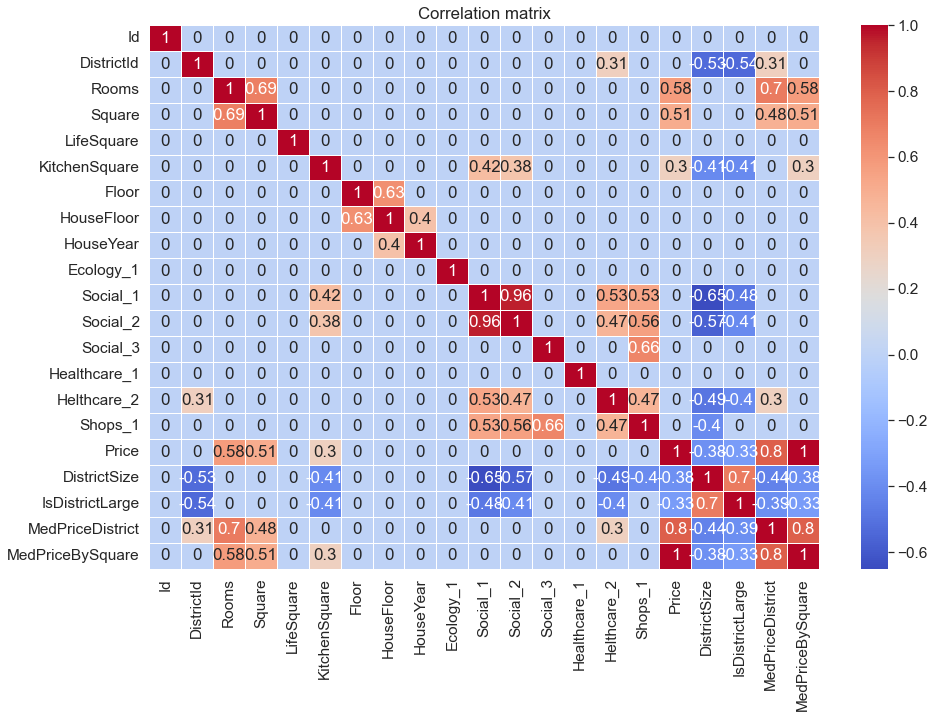

In [397]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df2.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [398]:
df2.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceDistrict',
 'MedPriceBySquare']

In [399]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Id                9742 non-null   int16   
 1   DistrictId        9742 non-null   int16   
 2   Rooms             9742 non-null   int8    
 3   Square            9742 non-null   float32 
 4   LifeSquare        9742 non-null   float32 
 5   KitchenSquare     9742 non-null   float32 
 6   Floor             9742 non-null   int64   
 7   HouseFloor        9742 non-null   int8    
 8   HouseYear         9742 non-null   int32   
 9   Ecology_1         9742 non-null   float32 
 10  Ecology_3         9742 non-null   category
 11  Social_1          9742 non-null   int8    
 12  Social_2          9742 non-null   int16   
 13  Social_3          9742 non-null   int16   
 14  Healthcare_1      9742 non-null   float32 
 15  Helthcare_2       9742 non-null   int8    
 16  Shops_1           9742 n

In [400]:
feature_names = ['Rooms','Square','LifeSquare','KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_3_bin', 
                 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'DistrictSize']
new_feature_names = ['IsDistrictLarge', 'MedPriceDistrict', 'MedPriceBySquare']
target_name = 'Price'

# Разбиение на train и test(validation)

In [401]:
X = df2[feature_names + new_feature_names]
y = df2[target_name ]

In [402]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 21)

# Построение модели

In [403]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Отложенная выборка

Train R2:	1.0
Test R2:	1.0


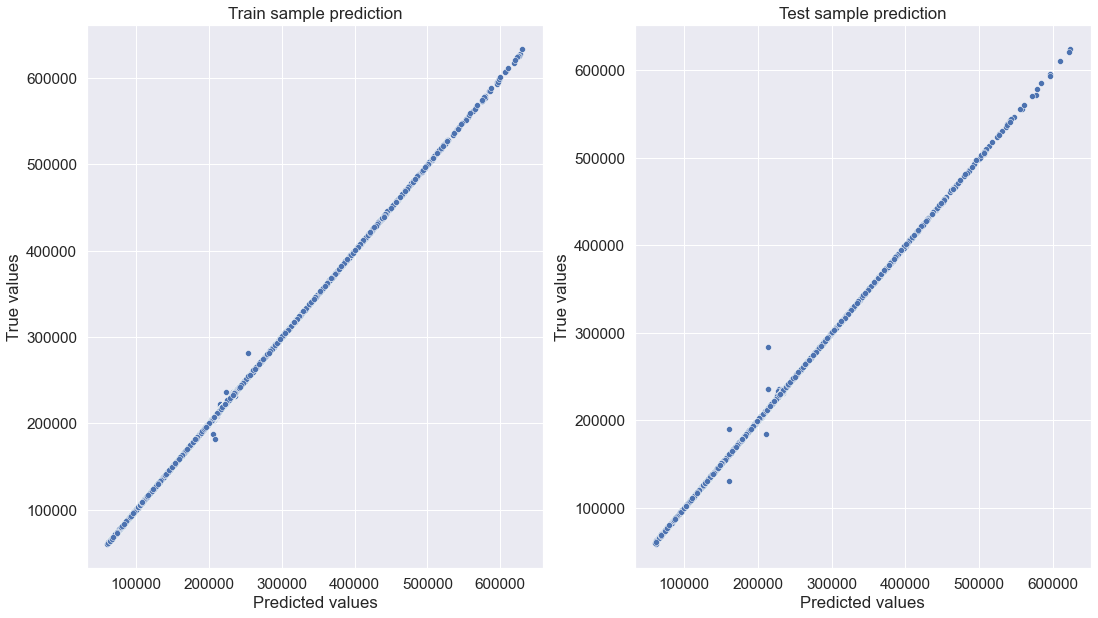

In [404]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

Перекрестная проверка

In [405]:
cv_score = cross_val_score(rf_model, X, y, scoring = 'r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.99966744, 0.99971517, 0.99979375])

In [406]:
cv_score.mean()

0.9997254541324937

Важность признаков

In [407]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by = 'importance', ascending=False)

,feature_name,importance
19,MedPriceBySquare,9.999283e-01
2,LifeSquare,1.826417e-05
1,Square,1.111828e-05
9,Social_1,7.897541e-06
7,Ecology_1,5.626068e-06
4,Floor,4.981189e-06
6,HouseYear,3.856794e-06
5,HouseFloor,3.335642e-06
10,Social_2,3.303907e-06
11,Social_3,2.923994e-06


# Прогназирование на тестовом датасете

In [794]:
# Привидение типов
df_test['DistrictId'] = df_test['DistrictId'].astype(str)
df_test['Id'] = df_test['Id'].astype(str)

In [795]:
df_test = pd.read_csv('./test.csv', sep=',')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [796]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [797]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [798]:
df['HouseFloor'] = df['HouseFloor'].fillna(0).astype('int64')

In [799]:
df['Rooms'] = df['Rooms'].fillna(0).astype('int64')

Воспользуемся фукцией reduce_mem_usage для уменьшения объема памяти, который занимает датасет

In [800]:
df_test_2 = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


Размер даных уменьшился на 70%.

### Обработка пропусков<a class='anchor' id='reduce'>

In [801]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

Из информации датафрейма, есть два признака с пропусками: LifeSquare и Healthcare_1

In [802]:
df_test_2.LifeSquare.isna().sum(), df_test_2.Healthcare_1.isna().sum()

(1041, 2377)

10% пропусков для признака LifeSquare и 24% пропусков для признака Healthcare_1. Мы не будем удалять данные, вместо этого воспользуемся статистиками.

In [803]:
df_test_2.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449501,36.158760,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,4832.674037,44.179466,0.838587,19.092793,17.825277,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [804]:
df_test_2.LifeSquare.median(), df_test_2.LifeSquare.mode()[0]

(32.925086975097656, 20.844322)

In [805]:
df_test_2.Healthcare_1.median(), df_test_2.Healthcare_1.mode()[0]

(900.0, 540.0)

Так как медиана меньше подвержена выбросам, то заменем пропуски медианой.

In [806]:
df_test_2.LifeSquare = df_test_2.LifeSquare.fillna(df_test_2.LifeSquare.median())
df_test_2.Healthcare_1 = df_test_2.Healthcare_1.fillna(df_test_2.Healthcare_1.median())

In [807]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   5000 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

### Обработка выбросов и нулевых значений для числовых признаков<a class='anchor' id='reduce'/>

In [808]:
df_test_2_num_features = df_test_2.select_dtypes(include=['float32', 'float16', 'int32', 'int8'])

In [809]:
df_test_2_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,1.910000,56.449501,35.485134,5.976800,8.632000,12.601000,0.119874,24.933800,1029.396362,1.31940,4.242800
std,0.838587,19.092793,15.915286,9.950147,5.483228,6.789167,0.120070,17.532202,766.589966,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906230,25.850152,1.000000,4.000000,9.000000,0.019509,6.000000,810.000000,0.00000,1.000000
50%,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,0.072158,25.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285130,41.769526,9.000000,12.000000,17.000000,0.195781,36.000000,990.000000,2.00000,6.000000
max,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,0.521867,74.000000,4849.000000,6.00000,23.000000


In [810]:
df_test_2_num_features[df2_num_features == 0].count()

Rooms               6
Square              0
LifeSquare          0
KitchenSquare     366
Floor               0
HouseFloor        146
Ecology_1         279
Social_1          102
Healthcare_1        0
Helthcare_2      2141
Shops_1          1193
dtype: int64

In [811]:
# Признак Rooms
df_test_2_num_features.Rooms.value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

Для признака Rooms преобладают значение 2, и количество комнат 0, 17 заменем их значения на медианное. 

In [812]:
df_test_2.loc[df_test_2['Rooms'].isin([0,17]),'Rooms'] = df_test_2['Rooms'].median()

In [813]:
df_test_2.Rooms.value_counts()

2.0    2033
1.0    1769
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

In [814]:
# Kitchen Square
df_test_2[df_test_2 == 0].count()

Id                  0
DistrictId         19
Rooms               0
Square              0
LifeSquare          0
KitchenSquare     335
Floor               0
HouseFloor        131
HouseYear           0
Ecology_1         279
Ecology_2           0
Ecology_3           0
Social_1          100
Social_2            0
Social_3         1470
Healthcare_1        1
Helthcare_2      2096
Shops_1          1150
Shops_2             0
dtype: int64

In [815]:
df_test_2['KitchenSquare'].value_counts().sort_index()

0.0       335
1.0      1191
2.0         4
3.0        11
4.0        21
5.0       612
6.0       595
7.0       297
8.0       606
9.0       417
10.0      558
11.0      107
12.0      132
13.0       33
14.0       20
15.0       17
16.0       13
17.0        5
18.0        3
19.0        2
20.0        2
22.0        1
24.0        1
30.0        1
33.0        1
34.0        1
40.0        1
41.0        1
42.0        3
44.0        1
57.0        1
60.0        1
61.0        1
62.0        1
65.0        1
97.0        1
112.0       1
620.0       1
Name: KitchenSquare, dtype: int64

Значения-выбросы, которые находятся за пределами квантиля 0.975, заменим на медианное

In [816]:
# Kitchen Square
df_test_2.loc[df_test_2['KitchenSquare'] > df_test_2['KitchenSquare'].quantile(0.975), 'KitchenSquare'] = df_test_2['KitchenSquare'].median() 
df_test_2.loc[df_test_2['KitchenSquare'] == 0, 'KitchenSquare'] = df_test_2['KitchenSquare'].median() 

In [817]:
df_test_2['KitchenSquare'].value_counts().sort_index()

1.0     1191
2.0        4
3.0       11
4.0       21
5.0      612
6.0     1044
7.0      297
8.0      606
9.0      417
10.0     558
11.0     107
12.0     132
Name: KitchenSquare, dtype: int64

In [818]:
df_test_2[df_test_2 == 0].count()

Id                  0
DistrictId         19
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor        131
HouseYear           0
Ecology_1         279
Ecology_2           0
Ecology_3           0
Social_1          100
Social_2            0
Social_3         1470
Healthcare_1        1
Helthcare_2      2096
Shops_1          1150
Shops_2             0
dtype: int64

In [819]:
df_test_2.shape

(5000, 19)

In [820]:
# HouseFloor, Floor
df_test_2.HouseFloor.sort_values().unique(), df_test_2.Floor.sort_values().unique()

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
        48., 99.], dtype=float32),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
        78], dtype=int8))

Так как недвижимость не может иметь этажность 0, то заменем нулевые значения признака HouseFloor на медианное.

In [821]:
df_test_2.loc[df_test_2.HouseFloor == 0, 'HouseFloor'] = df_test_2.HouseFloor.median()

In [822]:
floor_outliers_test = df_test_2.loc[df_test_2.Floor > df_test_2.HouseFloor].index

Заменем значения признака HouseFloor для индексов floor_outliers. Новым значением будет случайное число от 1 до х, где х - это этажность здания.

In [823]:
df_test_2.loc[floor_outliers_test, 'Floor'] = df_test_2.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [824]:
df_test_2[df_test_2 == 0].count()

Id                  0
DistrictId         19
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1         279
Ecology_2           0
Ecology_3           0
Social_1          100
Social_2            0
Social_3         1470
Healthcare_1        1
Helthcare_2      2096
Shops_1          1150
Shops_2             0
dtype: int64

Т.к. Ecology_1, Social_1_3, Helthcare_2, Shops_1 - являются описательными оказателями местности, для них нулевые значения отавим без изменений.

### Дубликаты записей<a class='anchor' id='reduce'/>

In [825]:
# отбрасываем неуникальные строки
df_dedupped = df_test_2.drop('Id', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(df_test_2.shape)
print(df_dedupped.shape)

(5000, 19)
(5000, 18)


Так как по условию задания, нам нужно получить прогноз для всех 5000 строк данных, дубликатные записи удаляться не будут.

In [826]:
df_test_2.shape

(5000, 19)

### Добавление новых признаков<a class='anchor' id='reduce'>

In [827]:
# Замена значений "А" и "В" у категориальных признаков на знаечения 0 и 1, соответственно.
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int64   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   5000 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [828]:
df_test_2['Shops_2_bin'] = df_test_2.Shops_2.replace({'A':0, 'B':1})
df_test_2['Ecology_2_bin'] = df_test_2.Ecology_2.replace({'A':0, 'B':1})
df_test_2['Ecology_3_bin'] = df_test_2.Ecology_3.replace({'A':0, 'B':1})

In [829]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int64   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   5000 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [830]:
df_test_2.LifeSquare = df_test_2.LifeSquare.fillna(df_test_2.LifeSquare.median())

In [831]:
# DistrictSize, IsDistrictLarge
district_size = df_test_2.DistrictId.value_counts().reset_index().rename(columns = {'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


Предположим, что размер района будет влиять нас стоймость недвижимости

In [832]:
df_test_2 = df_test_2.merge(district_size, on = 'DistrictId', how = 'left')
df_test_2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Shops_2_bin,Ecology_2_bin,Ecology_3_bin,DistrictSize
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,...,2748,1,900.0,0,0,B,1,1,1,91
1,15856,74,2.0,69.263184,32.925087,1.0,1,1.0,1977,0.075779,...,1437,3,900.0,0,2,B,1,1,1,61
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,2
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,900.0,3,3,B,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,900.0,0,0,A,0,1,1,391


Определим районы, количество недвижимости в которых больше 100.

In [833]:
(df_test_2.DistrictSize > 100).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

Создадим признак IsDistrictLarge. 1 - недвижимость находится в большом районе, 0 - в маленьком.

In [834]:
df_test_2['IsDistrictLarge'] = (df_test_2.DistrictSize > 100).astype(int)
df_test_2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Shops_2_bin,Ecology_2_bin,Ecology_3_bin,DistrictSize,IsDistrictLarge
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,1,1,1,91,0
1,15856,74,2.0,69.263184,32.925087,1.0,1,1.0,1977,0.075779,...,3,900.0,0,2,B,1,1,1,61,0
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,B,1,1,1,2,0
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,1,1,1,49,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,0,1,1,391,1


### Список признаков test<a class='anchor' id='reduce'/>

In [835]:
df_test_2.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Shops_2_bin',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'DistrictSize',
 'IsDistrictLarge']

In [836]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               5000 non-null   int16   
 1   DistrictId       5000 non-null   int16   
 2   Rooms            5000 non-null   float32 
 3   Square           5000 non-null   float32 
 4   LifeSquare       5000 non-null   float32 
 5   KitchenSquare    5000 non-null   float32 
 6   Floor            5000 non-null   int64   
 7   HouseFloor       5000 non-null   float32 
 8   HouseYear        5000 non-null   int16   
 9   Ecology_1        5000 non-null   float32 
 10  Ecology_2        5000 non-null   category
 11  Ecology_3        5000 non-null   category
 12  Social_1         5000 non-null   int8    
 13  Social_2         5000 non-null   int16   
 14  Social_3         5000 non-null   int16   
 15  Healthcare_1     5000 non-null   float32 
 16  Helthcare_2      5000 non-null   int8    


In [842]:
feature_names_test = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'Ecology_2_bin', 'Ecology_3_bin', 'DistrictSize', 'IsDistrictLarge']

In [843]:
X_test = df_test_2[feature_names_test]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DistrictId       5000 non-null   int16   
 1   Rooms            5000 non-null   float32 
 2   Square           5000 non-null   float32 
 3   LifeSquare       5000 non-null   float32 
 4   KitchenSquare    5000 non-null   float32 
 5   Floor            5000 non-null   int64   
 6   HouseFloor       5000 non-null   float32 
 7   HouseYear        5000 non-null   int16   
 8   Ecology_1        5000 non-null   float32 
 9   Social_1         5000 non-null   int8    
 10  Social_2         5000 non-null   int16   
 11  Social_3         5000 non-null   int16   
 12  Healthcare_1     5000 non-null   float32 
 13  Helthcare_2      5000 non-null   int8    
 14  Shops_1          5000 non-null   int8    
 15  Shops_2_bin      5000 non-null   category
 16  Ecology_2_bin    5000 non-null   category


In [845]:
# Прогнозирование цены для тестовой выборки
y_test_preds = rf_model.predict(X_test)
y_test_preds

array([61050.13023437, 61311.10859375, 61146.07183594, ...,
       61062.96359375, 61004.66457031, 61151.34132813])

In [861]:
predictions = pd.DataFrame({'Id': df_test_2.Id, 'Price': y_test_preds})

In [863]:
# Сохранение результатов
predictions.to_csv("LBulatova.csv")